# [Project] 뉴스기사 요약해보기
## 개요
뉴스 기사 데이터셋으로 추상적 요약과 추출적 요약을 모두 해봅니다.

## 목차
1. 데이터 수집하기
2. 데이터 전처리하기 (추상적 요약)
3. 어텐션 메커니즘 사용하기 (추상적 요약)
4. 실제 결과와 요약문 비교하기 (추상적 요약)
5. Summa을 이용해서 추출적 요약해보기
6. 추상적 요약과 추출적 요약 비교
7. 모델 성능 향상 시도

## 회고

## Reference
---

In [1]:
# 라이브러리 버전 확인
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


# 1. 데이터 수집하기
데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용합니다.  
[sunnysai12345/News_Summary](https://github.com/sunnysai12345/News_Summary)

In [2]:
# 데이터 다운로드
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
# 데이터 샘플 확인하기
data.sample(10)

,headlines,text
75402,"Red wine, black tea ingredient could prevent f...",US-based researchers have found a gut microbe ...
7880,"Ranveer dances to 'Chaiyya Chaiyya' with SRK, ...",A video shows Ranveer Singh dancing with Shah ...
47484,"Kohli wins 28th Man of Match award, third-most...",With his 28th Man of the Match award against S...
12167,"Saif Ali Khan, Radhika Apte starrer 'Baazaar' ...","Saif Ali Khan, Radhika Apte, Chitrangda Singh ..."
47388,Fastest ODI ton maker ABD also has a music alb...,ODI cricket history's fastest century maker AB...
70694,Rahul's foreign visits just 0.001% compared to...,Congress Spokesperson Abhishek Singhvi on Mond...
64410,Cisco buys US software company BroadSoft for $...,Cisco Systems on Monday said it will acquire U...
6099,My future lies there: Tanushree on returning t...,"Actress Tanushree Dutta, who earlier accused N..."
68957,Ukraine ambassador's phone snatched at Delhi's...,Ukrainian ambassador to India Igor Polikha's p...
36630,Indrani Mukerjea admitted to hospital in delir...,The prime accused in the Sheena Bora murder ca...


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

- 추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있습니다.  
- 추출적 요약을 하는 경우에는 오직 text열만을 사용합니다.

In [6]:
# 전체 데이터 수
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


# 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리와 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 봅니다.  
만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 봅니다.  

## 패키지 불러오기

In [4]:
# NLTK의 불용어 사전을 다운로드, 데이터 전처리를 위한 다른 패키지 불러오기

import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re   # 정규 표현식을 사용하기 위한 re (Regular Expression) 모듈
import matplotlib.pyplot as plt
from nltk.corpus import stopwords   # nltk에서 제공하는 불용어 데이터를 사용하기 위해 stopwords를 가져오기
from bs4 import BeautifulSoup       # HTML 또는 XML과 같은 마크업 언어에서 데이터를 추출하기 위한 BeautifulSoup 라이브러리를 가져오기
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')


# from tensorflow.keras.preprocessing.text import Tokenizer: 텍스트를 토큰화하기 위한 Keras의 Tokenizer를 가져옵니다.
# from tensorflow.keras.preprocessing.sequence import pad_sequences: 
# 시퀀스 데이터를 패딩하기 위한 Keras의 pad_sequences를 가져옵니다.
# import urllib.request: 웹에서 데이터를 다운로드하기 위한 urllib 라이브러리를 가져옵니다.
# import warnings: 경고 메시지를 처리하기 위한 warnings 모듈을 가져옵니다.
# warnings.filterwarnings("ignore", category=UserWarning, module='bs4'): 
# BeautifulSoup 모듈에서 발생하는 UserWarning을 무시하도록 경고 메시지를 필터링합니다.

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


=3


## 2-1. 데이터 정리하기
빈칸으로 존재하는 null 데이터, 의미는 같지만 다른 식으로 작성된 글 같은 중복 항목과 같은 학습할 때 방해가 되는 데이터를 먼저 솎아내겠습니다.  

### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [12]:
# 데이터의 중복 샘플 유무를 확인하기

print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Headline 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Headline 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [13]:
# 중복 샘플 제거하기 - 데이터프레임의 drop_duplicates()를 사용

data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

# subset은 중복을 검사할 때 어떤 컬럼 또는 컬럼의 집합을 기준으로 할지를 지정하는 매개변수
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다

전체 샘플수 : 98360


- drop_duplicates() 함수는 중복된 Null들을 완전히 삭제하지는 못할 수 있으므로 데이터에 Null 값이 남아있는지 확인해야 합니다.

In [14]:
# 데이터프레임에 Null 값이 있는지 확인 - .isnull().sum()을 사용

print(data.isnull().sum())

headlines    0
text         0
dtype: int64


전체 데이터에서 중복을 제거하였으며, null 값은 없습니다.

### 텍스트 정규화 : 동의어를 1개의 표현으로 통일시켜주어 기계의 연산량을 줄이기  
연산 속도를 높이기 위한 정규화 사전을 생성하여 문장의 형식을 통일화 시킨다.

In [15]:
# 텍스트 정규화를 위한 사전 구성

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


### 불용어 처리
일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들이 존재합니다.  
이를 불용어(stopwords)라고 부릅니다. 때로는 불용어를 제거하는 것이 자연어 처리의 성능을 높이는 방법일 수 있습니다.  
여기서는 NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거해보겠습니다.  
ex. ummmmmmmmm -> umm

In [16]:
# 불용어 개수와 불용어 확인하기

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

#### 최종적인 불용어 제거 작업  

- NLTK에서 미리 정의하여 제공하고 있는 불용어 제거
- 모든 영어 문자는 소문자로 만들기
- 섞여있는 html 태그를 제거
- 정규 표현식을 통해 각종 특수문자를 제거  
위의 작업으로 정말 필요한 내용만 잘 학습할 수 있도록 처리하겠습니다.

#### NLTK를 이용해 불용어를 제거하는 파트  

- Text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 짧은 Headline 전처리할 때는 호출하지 않을 것
- Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 Headline에는 남아 있는 게 더 좋음
- 이 처리를 위해서 함수의 인자로 remove_stopwords를 추가하고, if문을 추가

In [17]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Headline)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

# sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) 
# 텍스트 내의 약어를 정규화하는 과정을 수행
# contractions는 축약형을 키(key)로 가지고, 해당 축약형을 전체 단어로 대체할 값을 값(value)으로 가지는 딕셔너리
# 예를 들어, "I'm"은 "I am"으로 변환되고, "won't"은 "will not"으로 변환

=3


In [18]:
# 임의의 text와 summary를 만들어 함수를 호출해보기 (함수가 잘 만들어졌는지 확인)

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headline = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headline:", preprocess_sentence(temp_headline, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headline: great way to start the day


#### 훈련 데이터 전체에 대해서 불용어 전처리 수행  
- Text : 불용어를 제거 O
- Headline : 불용어를 제거 X 
- 따라서 Text, Headline 따로 호출해서 진행   

먼저 Text를 전처리하고, 결과를 확인하기 위해서 상위 5개의 줄을 출력해보겠습니다.

In [19]:
# 전체 Text 데이터에 대한 전처리 
clean_text = []

# 판다스 데이터프레임의 행(row)을 순회하는 함수 iterrows()를 활용
for i, row in data.iterrows():
    # "Text" 컬럼에 대한 전처리
    preprocessed_text = preprocess_sentence(row['text'], remove_stopwords=True)
    
    # 결과를 clean_text 리스트에 추가
    clean_text.append(preprocessed_text)

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [22]:
# 전체 Headline 데이터에 대한 전처리 
clean_headline = []

# 판다스 데이터프레임의 행(row)을 순회하는 함수 iterrows()를 활용
for i, row in data.iterrows():
    # "Headline" 컬럼에 대한 전처리
    preprocessed_headline = preprocess_sentence(row['headlines'], remove_stopwords=False)

    # 결과를 clean_headline 리스트에 추가
    clean_headline.append(preprocessed_headline)

print("Headline 전처리 후 결과: ", clean_headline[:5])

Headline 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


- 텍스트 정제 과정을 거친 후에는 빈(empty) 샘플이 생겼는지 확인  
    -> 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체합니다.  

- 보다 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장하기

In [23]:
# 기존의 data를 전처리 된 data로 치환
data['text'] = clean_text
data['headlines'] = clean_headline

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [24]:
# Null 값이 생겼는지 재확인 - .isnull().sum()을 사용하여
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [25]:
# 정제 과정 후 빈 샘플(null)이 생기지 않았으나 혹시 모르니 모두 제거하기 

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## 2-2. 훈련데이터와 테스트데이터 나누기
학습을 진행하기 위해서는 학습에 사용할 데이터의 크기를 결정하고, 문장의 시작과 끝을 표시해 주어야 합니다.  

### 훈련 데이터 샘플의 최대 길이 정하기
Text와 Headline의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해서 보겠습니다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


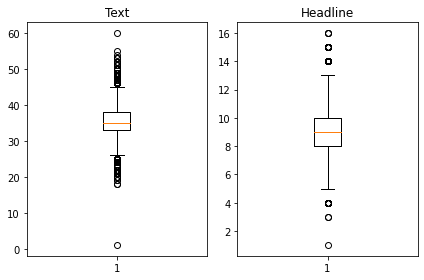

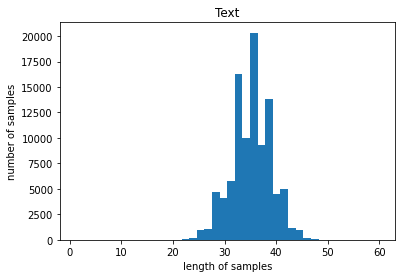

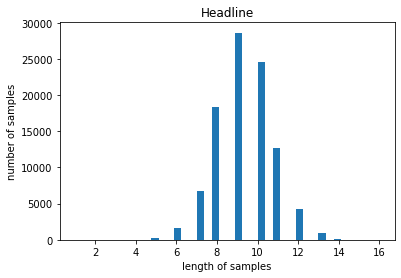

In [26]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headline_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headline_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headline_len)
plt.title('Headline')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headline')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# bins는 히스토그램에서 데이터를 나누는 구간의 개수를 지정하는 매개변수입니다. 
# 히스토그램은 데이터를 구간으로 나누고 각 구간에 속하는 데이터의 개수를 나타내는 그래프입니다. 

### Text 그래프 분석

- boxplot : Text의 경우 최소 길이가 1, 최대 길이가 60, 평균 길이다 35이다.
- 히스토그램(hist) : 평균 길이에서 가장 개수가 많으며 정규분포를 띈다.

### Summary 그래프 분석

- boxplot : 최소 길이가 1, 최대 길이가 16, 그리고 평균 길이가 9로 Text에 비해 상대적으로 길이가 짧다.
- 히스토그램(hist) : 평균 길이에서 가장 개수가 많으며 정규분포를 띈다.

> 사용할 train data의 길이를 제한하지 않고 그대로 사용합니다. 그 이유는 아래와 같습니다.  
> - 데이터가 정규분포를 이루며, 분산이 크지 않기 때문
> - 뉴스 본문과 헤드라인의 경우, 텍스트의 길이가 다르고 의미적인 정보가 주로 헤드라인에 집중되는 경우가 많습니다.  
> 따라서 헤드라인(의미있는 정보)에 집중하여 모델이 더 간결하고 효과적으로 핵심 내용을 이해하도록 돕기 위해

### 시작 토큰과 종료 토큰 추가하기
- 디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈춥니다.
- 시작 토큰 SOS와 종료 토큰 EOS는 각각 start of a sequence와 end of a sequence를 나타냅니다.  

seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가해야 합니다.  
- 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가합니다.
- decoder_input : 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름
- decoder_target : 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름  

두 개의 문장 모두 headlines 열로부터 만듭니다.

In [27]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


'decoder_input'의 앞에 'sostoken' 을 추가, 'decoder_target'의 끝에는 'eostoken'을 추가 완료  

- 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장하기

In [28]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 Numpy 타입으로 저장

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [29]:
# shape 확인
print(encoder_input.shape)
print(decoder_input.shape)
print(decoder_target.shape)

(98360,)
(98360,)
(98360,)


### 훈련 데이터와 테스트 데이터를 분리하기
훈련, 테스트 데이터를 직접 분리해보겠습니다.  
우선, encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어줍니다.

In [30]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 만들기

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[23652 22618 90908 ... 61646 84919 80880]


In [33]:
# 원래 encoder_input의 shape
print(encoder_input.shape)

# 셔플된 정수 시퀀스의 shape
print(indices.shape)

# 셔플된 정수 시퀀스 길이
# print(len(indices))

(98360,)
(98360,)


In [34]:
# 정수 시퀀스의 배열(indices)을 이용하여 잘 섞인 샘플(encoder_input, decoder_input, decoder_target) 만들기

encoder_input = encoder_input[indices]   # encoder_input 배열의 행을 indices에 주어진 순서대로 재배열
decoder_input = decoder_input[indices]   # decoder_input 배열의 행을 indices에 주어진 순서대로 재배열
decoder_target = decoder_target[indices] # decoder_target 배열의 행을 indices에 주어진 순서대로 재배열

print(encoder_input.shape)
print(decoder_input.shape)
print(decoder_target.shape)

(98360,)
(98360,)
(98360,)


#### 셔플된 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의해줍니다.

In [35]:
# test data 크기 정하기 - 전체 데이터의 20%

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19672


이렇게 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분합니다.

In [36]:
# 전체 데이터를 각각의 train, test data로 나누기

encoder_input_train = encoder_input[:-n_of_val]   # 전체데이터의 처음부터 테스트데이터(20%) 전까지 = 80%
decoder_input_train = decoder_input[:-n_of_val]   # 디코더입력의 처음부터 테스트데이터(20%) 전까지 = 80%
decoder_target_train = decoder_target[:-n_of_val] # 디코더레이블의 처음부터 테스트데이터(20%) 전까지 = 80%

encoder_input_test = encoder_input[-n_of_val:]    # 전체데이터의 나머지 = 20%
decoder_input_test = decoder_input[-n_of_val:]    # 디코더입력의 나머지 = 20%
decoder_target_test = decoder_target[-n_of_val:]  # 디코더레이블의 나머지 = 20%

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


## 2-3. 정수 인코딩
### 단어 집합(vocabulary) 만들기 및 정수 인코딩  
- 단어 집합 만들기란 훈련 데이터와 테스트 데이터의 각 단어에 고유한 정수를 맵핑하는 작업 (기계가 텍스트를 숫자로 처리할 수 있도록)
- Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있습니다.  

우선, 원문에 해당되는 encoder_input_train에 대해서 단어 집합을 만들겠습니다.

In [37]:
# 훈련 데이터에 대한 단어 집합 만들기 - keras의 토크나이저 사용

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성


# 토큰화가 잘 되었는지 확인
list(src_tokenizer.word_index.items())[:10]

[('said', 1),
 ('india', 2),
 ('year', 3),
 ('added', 4),
 ('us', 5),
 ('also', 6),
 ('first', 7),
 ('government', 8),
 ('police', 9),
 ('people', 10)]

단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었습니다.  
또한 현재 생성된 단어 집합은 src_tokenizer.word_index에 저장되어 있습니다.

- src_tokenizer.fit_on_texts() : 입력된 데이터로부터 단어 집합 생성 
- src_tokenizer.word_index : 생성된 단어 집합이 저장된 곳
- src_tokenizer.word_counts.items() : 단어와 각 단어의 등장 빈도수가 저장되어있는 통계적인 정보를 얻을 수 있는 곳  

### 훈련 데이터의 희귀 단어 제외

단어 집합에 있는 모든 단어를 사용하는 것이 아니라, **빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행**하려 합니다.  
등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해보겠습니다.

In [38]:
# 빈도수가 낮은 단어의 비중 확인 (threshold = 7)
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69730
등장 빈도가 6번 이하인 희귀 단어의 수: 47605
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22125
단어 집합에서 희귀 단어의 비율: 68.27047181987666
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5068160834223434


#### 통계 정보 해석
- encoder_input_train에는 7만여 개의 단어가 있습니다.
- 등장 빈도가 threshold 값인 7회 미만, 즉 6회 이하인 단어들은 단어 집합에서 무려 70% 내외를 차지합니다.
- 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.50%밖에 되지 않습니다.
- 그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 합니다.
- 위에서 이를 제외한 단어 집합의 크기를 22,000여 개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 22,000으로 제한해보겠습니다.
- 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있습니다.

In [39]:
# 단어 집합의 크기 제한 (22,000개)

src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 22,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [40]:
# 위의 텍스트 시퀀스를 정수 시퀀스로 변환
# texts_to_sequences() : 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[8542, 8409, 6242, 5100, 7808, 213, 32, 276, 52, 412, 843, 2552, 306, 8409, 1584, 2821, 623, 1000, 32, 690, 589, 29, 131, 122, 202, 1522, 287, 1259, 756, 306, 11523, 11, 266, 19461, 80, 756, 914, 1355, 11523, 8041], [261, 449, 31, 2891, 3283, 60, 20653, 7689, 1017, 523, 289, 770, 1910, 73, 233, 126, 516, 5707, 4970, 360, 978, 448, 1372, 39, 169, 11, 978, 112, 81, 978, 1688, 162, 45, 3432, 289], [1843, 3892, 2524, 73, 109, 2562, 13796, 426, 641, 986, 1246, 555, 204, 118, 1246, 249, 834, 90, 2524, 1427, 5986, 1046, 3264, 3506, 1428, 375, 1590, 2524, 314, 249, 2892, 7, 37, 212, 834, 210, 20654, 14248, 5062, 834, 29, 176]]


- 이제 더 이상 텍스트 데이터가 아니라 정수가 나오고 있습니다.
- 현재 단어 집합의 크기를 22,000으로 제한했으니까 이제 22,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않습니다.

### Headline 데이터의 희귀 단어 제외 
Headline 데이터에 대해서도 동일한 작업을 수행합니다.  
케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산합니다.

In [42]:
# decoder_input_train에 대한 단어 집합 만들기 - 케라스의 토크나이저를 사용하여
# = 훈련 데이터의 레이블 = Headline 데이터

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)   # 전체 단어 집합과 각 단어에 대한 빈도수 계산
print('=3')

=3


#### Headline 데이터 내 희귀단어의 비중 확인하기
tar_tokenizer.word_counts.items()을 사용하여 등장 빈도수가 6회 미만인 단어들의 비중을 확인합니다.

In [43]:
# decoder_input_train - 단어와 단어의 등장 빈도수 통계 정보  

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30096
등장 빈도가 5번 이하인 희귀 단어의 수: 19687
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10409
단어 집합에서 희귀 단어의 비율: 65.41400850611377
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.646938770473801


#### 통계 정보 해석
- 등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 65%를 차지하고 있습니다.
- 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 4.64%밖에 되지 않습니다.
- 아까 했던 것과 동일하게 이 단어들은 모두 제거합니다.
- 어림잡아 10,000을 단어 집합의 크기로 제한합니다.

In [44]:
# 단어 집합 만들기 (크기=10000으로 제한)
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab)    # 단어 집합 만드는 Tokenizer 사용 - 단어 개수 10,000개로 제한
tar_tokenizer.fit_on_texts(decoder_input_train)   # 단어 집합 만들기 : decoder_input_train
tar_tokenizer.fit_on_texts(decoder_target_train)  # 단어 집합 만들기 : decoder_target_train

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 58, 406, 5419, 3499, 9486, 150, 14, 5906, 651, 1025], [1, 1297, 1526, 1608, 285, 6480, 1199, 4], [1, 1431, 241, 7225, 6859, 11, 91, 1745, 179, 641], [1, 472, 120, 759, 172, 14, 187, 15, 7226, 7675], [1, 33, 114, 905, 2173, 422, 15, 906, 5, 868, 3094]]
target
decoder  [[58, 406, 5419, 3499, 9486, 150, 14, 5906, 651, 1025, 2], [1297, 1526, 1608, 285, 6480, 1199, 4, 2], [1431, 241, 7225, 6859, 11, 91, 1745, 179, 641, 2], [472, 120, 759, 172, 14, 187, 15, 7226, 7675, 2], [33, 114, 905, 2173, 422, 15, 906, 5, 868, 3094, 2]]


정상적으로 정수 인코딩 작업이 끝났습니다.  
현재 decoder_input_train과 decoder_target_train에는 더 이상 숫자 10,000이 넘는 숫자들은 존재하지 않습니다.  

**패딩 하기 전 한 가지 점검사항!**
- 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것 = 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있다.
- text에 비해 평균 길이가 짧은 headline에서 빈 샘플이 많아지기 쉬울 것이다.  

=> headline에서 길이가 0이 된 샘플들의 인덱스를 받아와서 확인해보자!  
- headline인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이며,
- 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않는다.
- 그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나올 것 (sos 또는 eos만 남아있으므로)  

#### 빈 샘플의 인덱스를 변수에 담기
훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해봅니다.  
이 샘플들은 모두 삭제하겠습니다.

In [45]:
# 빈 샘플 삭제하기

# 빈 샘플의 인덱스를 변수에 담기 - 빈 샘플인지는 decoder_input에서 확인
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

# decoder_input_train에서 빈 샘플이 없는 경우만 train data들에 남기기
encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

# decoder_input_test에서 빈 샘플이 없는 경우만 test data들에 남기기
encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


> 빈 샘플이 없음을 확인할 수 있습니다.  

### 패딩하기
서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 합니다.  
- 최대 길이는 text, headlines의 최대 길이인 60, 16으로 각각 설정합니다.
- 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰줍니다.

In [48]:
# 패딩하기
text_max_len = 60
headlines_max_len = 16

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

# padding='post' 옵션은 시퀀스의 뒷부분에 패딩을 추가하는 것을 의미합니다. 패딩된 부분은 0으로 채워집니다.

=3


In [49]:
# 패딩이 되었는지 확인 
encoder_input_train

array([[8542, 8409, 6242, ...,    0,    0,    0],
       [ 261,  449,   31, ...,    0,    0,    0],
       [1843, 3892, 2524, ...,    0,    0,    0],
       ...,
       [3542,  684, 1295, ...,    0,    0,    0],
       [9564,   50, 3167, ...,    0,    0,    0],
       [   5,   16,  124, ...,    0,    0,    0]], dtype=int32)

뒷부분에 0이 추가되어 패딩이 된 것을 확인할 수 있습니다.  
이제 학습에 필요한 데이터 전처리가 모두 완료되었습니다.

# 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있습니다.  
실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 봅니다.

## 인코더 설계
함수형 API를 이용해서 인코더를 설계합니다.

In [50]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256   # 단기 상태

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)
# Embedding(훈련 데이터의 단어 집합 크기, embedding_dim)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)


# hidden_size: LSTM 레이어의 은닉 상태의 크기 또는 차원을 나타냅니다.
# return_sequences=True: LSTM 레이어가 시퀀스 전체에 대한 출력을 반환하도록 지정합니다. 
# True로 설정되면 각 타임 스텝에서의 출력이 모델의 다음 레이어로 전달됩니다.
# return_state=True: LSTM 레이어가 마지막 타임 스텝의 출력뿐만 아니라 마지막 타임 스텝의 은닉 상태도 반환하도록 지정합니다.
# dropout=0.4: LSTM 셀의 입력에 대한 드롭아웃 비율을 나타냅니다. 모델의 과적합을 방지하기 위해 사용되는 정규화 기법 중 하나입니다.
# recurrent_dropout=0.4: LSTM 셀의 순환 상태에 대한 드롭아웃 비율을 나타냅니다. 이는 순환 상태의 드롭아웃으로, 시간에 따른 은닉 상태의 변화를 제어합니다.


- 임베딩 벡터의 차원은 128로 정의하고, hidden state의 크기를 256으로 정의
- hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터
- 인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높임
- 일반적인 dropout은 레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결해주는 방법  

## 디코더 설계

In [51]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))   # 디코더의 입력 시퀀스를 나타내는 텐서

# 디코더의 임베딩 층 
dec_emb_layer = Embedding(tar_vocab, embedding_dim)   # 목표 언어의 어휘 크기와 임베딩 차원을 가지고 있다.
dec_emb = dec_emb_layer(decoder_inputs)   # 디코더의 입력 시퀀스에 대한 임베딩을 수행

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# decoder_lstm : 
# 디코더의 LSTM 레이어. 이 LSTM 레이어는 인코더의 최종 은닉 상태와 셀 상태를 초기 상태로 받아들입니다. 
# 또한, return_sequences=True로 설정되어 시퀀스 전체에 대한 출력을 반환합니다.
# decoder_outputs: 
# 디코더 LSTM 레이어의 출력입니다. 이는 디코더의 각 타임 스텝에서의 출력으로 이루어진 시퀀스입니다. 
# 나중에 소프트맥스 레이어를 통과하여 최종적인 예측을 얻을 수 있습니다.

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일합니다.
하지만 **LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야** 합니다.  

## 디코더의 출력층 설계

In [52]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 어텐션 메커니즘
- 어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 뜻입니다.
- 여기서는 TensorFlow에 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 확인해봅니다.
- 어텐션 함수는 Bahdanau 스타일의 어텐션을 사용하였습니다. 

In [53]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고,  
어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있습니다.

## 모델 훈련하기
EarlyStopping을 활용하여 모델 훈련을 최적점에서 멈춥니다. (epochs가 아무리 크게 설정되어 있어도)

In [54]:
# 모델 훈련
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 50s 138ms/step - loss: 4.2788 - val_loss: 3.8943
Epoch 2/50
308/308 [==============================] - 42s 135ms/step - loss: 3.7957 - val_loss: 3.6359
Epoch 3/50
308/308 [==============================] - 42s 135ms/step - loss: 3.5569 - val_loss: 3.4562
Epoch 4/50
308/308 [==============================] - 42s 135ms/step - loss: 3.3628 - val_loss: 3.3165
Epoch 5/50
308/308 [==============================] - 42s 135ms/step - loss: 3.2058 - val_loss: 3.2078
Epoch 6/50
308/308 [==============================] - 42s 135ms/step - loss: 3.0735 - val_loss: 3.1256
Epoch 7/50
308/308 [==============================] - 42s 135ms/step - loss: 2.9613 - val_loss: 3.0385
Epoch 8/50
308/308 [==============================] - 42s 135ms/step - loss: 2.8628 - val_loss: 2.9870
Epoch 9/50
308/308 [==============================] - 42s 135ms/step - loss: 2.7760 - val_loss: 2.9382
Epoch 10/50
308/308 [==============================] - 42s 135ms/step - l

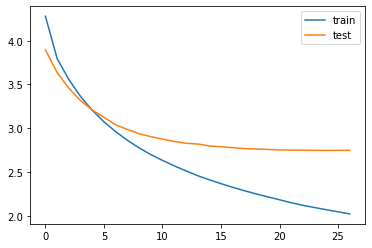

In [55]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 인퍼런스 모델 구현하기
테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.  

In [56]:
# [테스트 단계] '정수 인덱스 행렬 -> 실제 데이터로 복원' 을 위한 사전 준비
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 합니다.  

- 훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했습니다.  
- 그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

### 인퍼런스 단계의 인코더 모델 설계

In [57]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])
# 이 모델은 훈련된 인코더의 일부로, 디코더의 초개 상태를 얻기 위해 사용됩니다.

# 이전 시점의 상태들을 저장하는 텐서 - 디코더의 초기 상태를 받기 위한 입력 텐서를 생성 -> 추론 단계에서 디코더의 초기 상태 설정을 위해 사용됨.
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

# 디코더의 임베딩 적용 - 디코더의 입력 시퀀스에 대한 임베딩을 적용
dec_emb2 = dec_emb_layer(decoder_inputs)


# 디코더의 LSTM 실행
# 추론 단계에서 사용되어 디코더를 한 시점씩 진행하며 다음 단어를 예측
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


> 이렇게 구성된 모델은 훈련된 Seq2Seq 모델에서 인코더 부분과 일부 디코더 부분을 추출하여 훈련과정에서 사용한 모델과는 독립적으로 동작할 수 있습니다.

### 어텐션 메커니즘을 사용하는 출력층 설계

In [58]:
# 어텐션 메커니즘을 사용하는 출력층 설계

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))    # 인코더의 출력과 어텐션을 계산하기 위한 입력
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)    # 다음 단어의 확률 분포를 계산

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')


# attn_out_inf : 어텐션의 결과로,
# 디코더의 출력 (decoder_outputs2)과 인코더의 출력 (decoder_hidden_state_input)을 입력으로 받아 어텐션을 계산

# decoder_model : 디코더의 동작을 정의하는 모델로, 
# 입력으로 디코더의 초기 상태와 어텐션을 계산한 결과를 받고, 출력으로 다음 단어의 확률 분포와 업데이트된 상태를 반환합니다.

=3


> 이렇게 구성된 디코더 모델은 훈련된 Seq2Seq 모델에서 디코더 부분을 추출하여, 새로운 입력에 대해 시퀀스를 생성하는 데 사용됩니다.

### 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

In [62]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    # input_seq에 대한 인코더의 출력 (e_out) 및 마지막 은닉 상태 (e_h) 및 마지막 셀 상태 (e_c)를 반환
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    # 디코더 입력 시퀀스를 초기화하고, <SOS> (시작 토큰)에 해당하는 인덱스로 설정
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    # stop_condition이 True가 될 때까지 루프 반복 : <EOS> (종료 토큰)에 도달하거나 최대 요약 길이에 도달할 때까지 계속 반복
    while not stop_condition: 

        # 디코더 모델에 대한 예측: decoder_model을 사용하여 디코더의 출력 토큰, 새로운 은닉 상태 (h), 새로운 셀 상태 (c)를 얻습니다.
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        # 샘플링된 토큰 확인 및 문장 구성: 디코더의 출력 중 가장 확률이 높은 토큰을 샘플링합니다.
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        # 디코딩 결과 및 중단 조건 확인: 디코딩된 토큰을 결과 문장에 추가하고, <EOS>에 도달하거나 최대 길이에 도달하면 디코딩을 중단합니다.
        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


# 4. 실제 결과와 요약문 비교하기 (추상적 요약)
## Model Test
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 봅니다.  
테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편합니다. 이를 함수로 만들어 활용합니다.  
- Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고
- Headline의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만듭니다.

In [63]:
# Headline의 정수 시퀀스를 텍스트로 변환하는 seq2summary 함수 만들기

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if i == tar_word_to_index['eostoken']:
            break
        if i != 0 and i != tar_word_to_index['sostoken']:
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')


# temp : 문자열을 저장하는 변수

=3


In [64]:
# 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교하기

for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : us carrier united airlines ceo oscar munoz chosen take bonus send message accountability company chairman robert seek election announcement comes wake passenger dragging incident april last year munoz compensation totalled million nearly half compensation received 
실제 요약 : united airlines ceo skips bonus chairman to step down 
예측 요약 :  united ceo says he was ceo of united man


원문 : five indian fishermen arrested sri lankan navy allegedly fishing territory using boats region fishermen leader emerald called arrest saying centre told issues discussed sri lankan wickremesinghe visit india sorted 
실제 요약 : indian fishermen held for allegedly fishing in sri lanka 
예측 요약 :  indian fishermen detained in sri lanka for days


원문 : salman khan rumoured girlfriend iulia vantur released version song featured film sultan original song salman film lead actress anushka sharma recreated version stars iulia sharing video iulia tweeted one first hindi songs learned 
실제 요약 : iulia version of salman s

1가지 샘플을 가져와서 비교해보겠습니다.  
- 원문 : us carrier united airlines ceo oscar munoz chosen take bonus send message accountability company chairman robert seek election announcement comes wake passenger dragging incident april last year munoz compensation totalled million nearly half compensation received 
- 번역 : US Carrier United Airlines의 CEO 오스카 무노즈가 보너스를 받음 메시지 보내기 책임 회사 회장 로버트 추구 선거 발표 작년 4월 승객 끌림 사건이 발생함 무노즈 보상 총액이 백만 달러에 가까운 보상을 받음
- 실제 요약 : united airlines ceo skips bonus chairman to step down
- 예측 요약 :  united ceo says he was ceo of united man
- [문법 오류 수정]실제 요약 : United Airlines CEO skips bonus Chairman to step down
- [문법 오류 수정]예측 요약 : The United CEO said that he was the CEO of United, man.  

원문 자체도 해석하기가 쉽진 않아 어떤 요약이 더 정확한지 판단하기가 어렵습니다.    
그러나 아래 2가지를 기준으로 평가한다면,   

|평가 항목|실제 요약|예측 요약|
|---|---|---|
|문법 완성도|대소문자 전처리로 인한 오류가 있습니다.|시제 등 대소문자 오류 외의 문법 오류가 있습니다.|
|핵심단어 포함|bonus 등의 핵심 단어가 조금 더 포함되어 있습니다.|주어, 동사 외의 핵심단어가 거의 보이지 않습니다.|  

따라서 실제 요약이 원문에 조금 더 가까운 요약으로 보이며, 예측 요약은 핵심 단어 포함과 문법 완성도 모두 향상될 필요가 있습니다.  
모델 성능 향상, 데이터에 적합한 전처리 조정(원문의 핵심단어를 살리는) 등으로 정확도를 높이는 것이 좋아보입니다.

# 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높습니다.  
반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮습니다.  

Summa의 summarize(추출적 요약을 위한 모듈)를 사용하여 추출적 요약을 해봅니다.  

## 데이터 다운로드하기

In [65]:
# data download
import requests
from summa.summarizer import summarize

In [75]:
# 뉴스의 headlines과 원문을 다운로드
data2 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [76]:
# 일부를 출력해보고, 잘 저장되었는지 확인하기
print(data2[:1500])

                                              headlines  \
0     upGrad learner switches to career in ML & Al w...   
1     Delhi techie wins free food from Swiggy for on...   
2     New Zealand end Rohit Sharma-led India's 12-ma...   
3     Aegon life iTerm insurance plan helps customer...   
4     Have known Hirani for yrs, what if MeToo claim...   
...                                                 ...   
1495  Have seen Sachin Tendulkar get angry but not M...   
1496  Player ensures wife stays dry in rain during A...   
1497  Federer denied entry into locker room by secur...   
1498  42/42 seats in West Bengal: CM Mamata's cutout...   
1499  Court refuses chargesheet by Delhi Police agai...   

                                                   text  
0     Saurav Kant, an alumnus of upGrad and IIIT-B's...  
1     Kunal Shah's credit card bill payment platform...  
2     New Zealand defeated India by 8 wickets in the...  
3     With Aegon Life iTerm Insurance plan, customer...  
4

## summarize 사용하기
Summa의 summarize()의 인자로 사용되는 값들에 대해서 알아봅니다.

- text (str) : 요약할 테스트.
- ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
- words (int or None, optional) – 출력에 포함할 단어 수.  

만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.  
- split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환   

Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행합니다.  
그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있습니다.  
비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여봅니다. 원문의 0.005%만을 출력하도록 설정했습니다.

In [77]:
# text 원문과 추출적 요약 비교하기  
for idx, text in enumerate(data2['text'][:10]):
    print(f'<Original_{idx+1}:> \n{text}')
    print(f'[Extractive Summary:] \n{summarize(text, words=20)}\n')   # 단어를 20개만 선택하도록 해보기

<Original_1:> 
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
[Extractive Summary:] 
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.

<Original_2:> 
Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
[Extractive Summary:] 
Users g

1가지 샘플을 가져와서 비교해보겠습니다.    
<Original_3:>   
New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.
[Extractive Summary:] 
The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.  
<원본_3:>  
뉴질랜드는 목요일 해밀턴에서 열린 네 번째 ODI에서 인도를 8위켓으로 꺾고 5경기 ODI 시리즈의 첫 경기에서 승리했습니다. 인도는 2018년 3월부터 12연승을 거둔 후 Rohit Sharma의 주장 아래 국제 경기에서 패했습니다. 이 경기에서 인도는 ODI 크리켓 역사상 7번째로 낮은 합계인 92점을 기록했습니다.

[Extractive Summary:]  
The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.  
[추출 요약:]  
이 경기에서 인도는 ODI 크리켓 역사상 7번째로 낮은 합계인 92점을 기록했습니다.


아래 2가지를 기준으로 평가한다면,   

|평가 항목|예측 요약(추출적)|
|---|---|
|문법 완성도|문법적 오류가 발생하였습니다.|
|핵심단어 포함|등장 빈도가 높지 않은 대명사 주어(뉴질랜드) 정보가 없어져 핵심 내용의 일부가 훼손되었습니다.|  

# Abstractive Summary (추상적 요약) vs Extractive Summary(Summa를 활용한 추출적 요약) 

추상적 요약 모델의 성능이 좀 더 향상되어야 비교가 가능하겠으나, 시간 관계 상 지금까지의 결과로 성능을 비교해보겠습니다.  
추상적 요약은 아래 샘플을 기반으로 작성하였습니다.  

|평가 항목|Abstractive Summary (추상적 요약)|Extractive Summary(추출적 요약)|
|------|---|---|
|문법 완성도|시제 오류가 보이지만 핵심 내용은 어느정도 파악할 수 있는 수준입니다.|관계대명사 등의 오류가 발생했지만 내용은 어느정도 파악할 수 있습니다.|
|핵심단어 포함|핵심단어의 일부가 누락(청소년 올림픽)되거나 변경되어(은메달-> 금메달) 전반적인 뉘앙스는 맞지만 세부 내용의 정확도가 떨어지는 문장이 되었습니다. |등장 빈도가 높지 않은 대명사 주어(뉴질랜드) 정보가 없어져 핵심 내용의 일부가 누락(뉴질랜드의 우승)되었습니다.|

  
- 문법적 오류는 두가지 방식 모두 발생하였으나 대략적인 내용은 파악할 수 있습니다.
- 핵심단어 포함 측면에서 핵심 키워드와 세부 키워드로 나누어 보았을 때 
    - 추상적 요약은 핵심 키워드는 포함되어있으나 세부 키워드는 누락되어 큰 맥락에서의 내용만 맞는 문장이 되었으나
    - 추출적 요약은 핵심 키워드 자체가 누락된 경우가 발생하여 핵심 주제의 정보 손실이 발생하였습니다.

### [참조] 추상적 요약 샘플
- 원문 : suraj india first medal athletics youth olympic games claiming silver medal men race walk event tuesday year old silver india third overall medal athletics history youth olympic games great feeling happy said win   
- 실제 요약 : wins india st athletics medal at youth olympics   
- 예측 요약 :  india win gold silver at asian games at asiad    

- 번역 : 수라즈 인도 첫 번째 메달 육상 청소년 올림픽 은메달 획득 남자 경주 경보 이벤트 화요일 세 은메달 인도 세 번째 종합 메달 육상 역사 청소년 올림픽 게임 좋은 느낌 행복하다고 말했다 승리
- 실제 요약 : 청소년 올림픽에서 인도 제1회 육상 메달 획득
- 예측 요약 : 인도가 아시아드 아시안 게임에서 금메달을 획득했습니다.

# 모델 성능 향상 시도
### 실험1 : loss를 줄이기 위해 optimizer를 Adam으로 변경

In [78]:
# 모델 성능 향상 시도 - optimizer를 Adam으로 변경

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy') # optimizer = adam
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1) # 조기 종료 조건 설정
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 48s 140ms/step - loss: 1.9868 - val_loss: 2.7147
Epoch 2/50
308/308 [==============================] - 41s 134ms/step - loss: 1.8674 - val_loss: 2.7123
Epoch 3/50
308/308 [==============================] - 42s 136ms/step - loss: 1.7866 - val_loss: 2.7191
Epoch 4/50
308/308 [==============================] - 42s 135ms/step - loss: 1.7205 - val_loss: 2.7352
Epoch 00004: early stopping


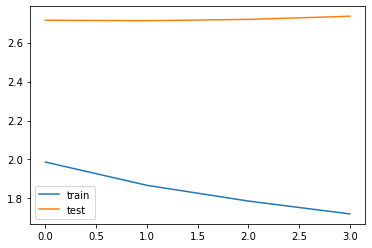

In [79]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

---
## 회고
### KEEP
- 어텐션 메커니즘의 작동 과정이 잘 이해되지 않아 [영상 자료](https://www.youtube.com/watch?v=Eb0bT7IXJh0)를 활용하였다.
- 2가지 추출방식을 표로 작성하여 직관성을 높였다.

### PROBLEM
- 모델 설계 : 단계 별 과정 아직 잘 안 들어온다.
- 모델 성능을 더 높일 필요가 있다.
- 요약 결과를 분석이 느리다.

### TRY
- 모델 설계의 단계와 코드를 복습한다. (여러 시각화, 작동 방식 자료를 찾아보며)
- 전체 단계를 더 익혀서 모델 성능에 시간을 투자하기
- 다양한 분석 방법과 관점 학습하기

---
## Reference
- [주피터 노트북 마크다운 표 작성방법](https://inasie.github.io/it%EC%9D%BC%EB%B0%98/%EB%A7%88%ED%81%AC%EB%8B%A4%EC%9A%B4-%ED%91%9C-%EB%A7%8C%EB%93%A4%EA%B8%B0/)
- [모델 성능 향상 방법](https://ai-for-everyone.medium.com/ai-%EB%AA%A8%EB%8D%B8-%EC%84%B1%EB%8A%A5%EC%9D%84-%EC%89%BD%EA%B3%A0-%EB%B9%A0%EB%A5%B4%EA%B2%8C-%EB%86%92%EC%9D%B4%EB%8A%94-%EB%B0%A9%EB%B2%95-%EC%95%A4%EB%93%9C%EB%A5%98-%EC%9D%91-%EA%B5%90%EC%88%98%EB%8B%98%EC%9D%98-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%A4%91%EC%8B%AC%EC%9D%98-ai-6595fa054ce6)

---

평가 방법  
- 매트릭이나 기준이 되는 수치를 기준으로 정량 평가
- 눈으로 보고 사람이 가진 인사이트로 평가하는 정성 평가  

생성형 모델의 기준은 2가지
- ROGUE Score : 레퍼런스 문장이 ㅇㅇ에 포함되는지? ngram기반으로 원래 헤드라인의 텍스트와 모델의 summary 비교해서 유사도 평가
- ROGUE Score와 반대되는 개념 뭔지 찾아보기

---
평가 기준 (루브릭)   
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.	
분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.
2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.	
모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었다.
3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.	  
두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다.

주로 30~40길이인데 100짜리 문장이 있을 때 생기는 문제점은?  
패딩값이 엄청 커지면 -> 모델이 패딩(0)을 더 많이 배워서 모델 성능이 매우 안좋아짐.. (+연산량이 매우 커짐)  
-> 전체적인 문장의 길이를 보고 적당히 잘라서 써야 한다!!

threshold 값 설정 기준?  
여러 개 출력해보고 괜찮은 거 선택